In [1]:
import tensorflow as tf
import numpy as np
from keras.layers import LSTM, Dense, Dropout, Input
import pandas as pd
from sklearn.model_selection import train_test_split
import datetime
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.models import Sequential

In [2]:
price_history = pd.read_csv('data/ETH_USD_11_20_2020-1_19_2021_historical_prices.csv', sep=';')
whales = pd.read_csv('data/transactions_aggregated_21_22.csv')
validators = pd.read_csv('data/validators_aggregated_21_22.csv')

# Basic cleaning
whales['date'] = pd.to_datetime(whales['datetime']).dt.date
validators['date'] = pd.to_datetime(validators['datetime']).dt.date

## Price history in price deltas includes datetime, price delta, and eth_volume
price_deltas = price_history.copy()[['timeOpen', 'close', 'volume']]
# price_deltas['delta'] = price_deltas['close'].diff().shift(-1)
price_deltas['delta'] = price_deltas['close'].pct_change()                  # Percent change function here
price_deltas['date'] = pd.to_datetime(price_deltas['timeOpen']).dt.date

In [ ]:
# Adjustable number of labels
num_labels = 5
labels = [x for x in range(num_labels)]

percentile_intervals = np.linspace(0, 100, num_labels + 1)
percentiles = np.percentile(price_deltas['delta'].dropna(), percentile_intervals[1:-1])
print(f"Percentiles ({percentile_intervals[1:-1]}):", percentiles)

levels = [-np.inf] + list(percentiles) + [np.inf]

price_deltas['labels'] = pd.cut(x=price_deltas['delta'], bins=levels, labels=labels)

Percentiles ([20. 40. 60. 80.]): [-0.02726268 -0.00783     0.00603285  0.02485177]


                   timeOpen        close        volume     delta        date  \
0  2025-04-23T00:00:00.000Z  1796.104189  2.290464e+10       NaN  2025-04-23   
1  2025-04-22T00:00:00.000Z  1757.331703  2.374792e+10 -0.021587  2025-04-22   
2  2025-04-21T00:00:00.000Z  1579.734556  1.540379e+10 -0.101061  2025-04-21   
3  2025-04-20T00:00:00.000Z  1587.514228  7.642784e+09  0.004925  2025-04-20   
4  2025-04-19T00:00:00.000Z  1612.922809  7.168139e+09  0.016005  2025-04-19   

  labels  
0    NaN  
1      1  
2      0  
3      2  
4      3  
            whale_avg_valueEth  whale_var_valueEth  whale_avg_gasPrice
date                                                                  
2021-01-01         9420.615145        2.907903e+08        9.104290e+10
2021-01-02         5493.719855        2.406098e+07        1.310462e+11
2021-01-03        13325.784826        1.492609e+08        2.976456e+11
2021-01-04        18190.842405        1.977588e+08        3.516557e+11
2021-01-05        10509.542

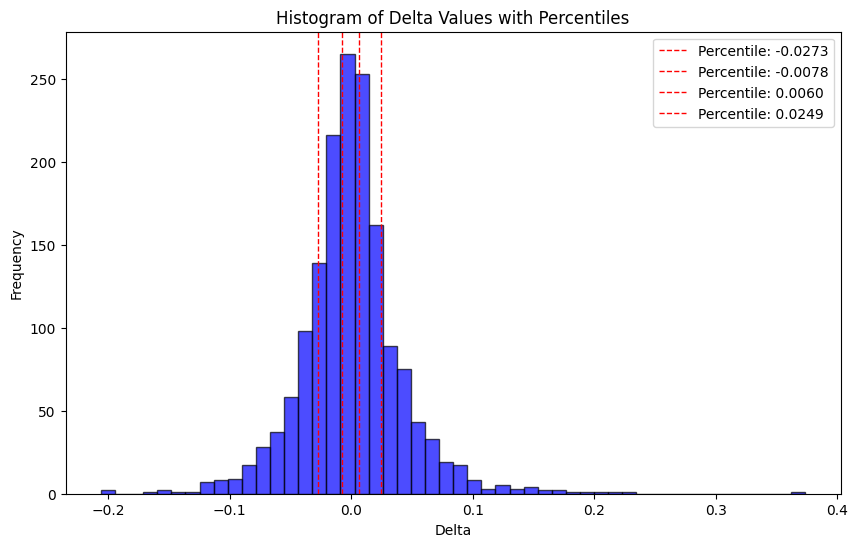

In [4]:
# TODO: Control center for aggregation strategy switching

# Aggregate whales
whale_aggregated = whales.groupby('date').agg(
    whale_avg_valueEth=('valueETH', 'mean'),
    whale_var_valueEth=('valueETH', 'var'),
    whale_avg_gasPrice=('gasPrice', 'mean')
)

# Aggregate validators
validators_aggregated = validators.groupby('date').agg(
    validator_count=('blockHash', 'nunique'),
    validator_gas_price=('gasPrice', 'mean'),
)

print(price_deltas.head())
print(whale_aggregated.head())
print(validators_aggregated.head())

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(price_deltas['delta'].dropna(), bins=50, alpha=0.7, color='blue', edgecolor='black')
for p in percentiles:
    plt.axvline(p, color='red', linestyle='dashed', linewidth=1, label=f'Percentile: {p:.4f}')
plt.title('Histogram of Delta Values with Percentiles')
plt.xlabel('Delta')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [5]:
# Dataset merging left onto labels
_intermediate = pd.merge(
    price_deltas,
    whale_aggregated,
    on='date',
    how='left'
)

labeled_data = pd.merge(
    _intermediate,
    validators_aggregated,
    on='date',
    how='left'
)

In [6]:
# Do checks, pull off final month of 2022 for testing
labeled_data.sort_values(by='date', inplace=True, ascending=True) 
labeled_data.dropna(inplace=True)

# Split into train and test
y = labeled_data['labels'].astype(int)
X = labeled_data[['whale_avg_valueEth', 'whale_var_valueEth', 'whale_avg_gasPrice', 'validator_count', 'validator_gas_price']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Assuming you have X_train, X_test, y_train, y_test, labels defined
window_length = 14
input_features = X_train.shape[1]

model = Sequential([
    Input(shape=(window_length, input_features)),
    LSTM(64, return_sequences=True),
    Dropout(0.5),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(len(labels), activation='softmax')  # Added activation='softmax' for classification
])

model.compile(
    optimizer="adam", 
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Function to create windowed sequences
def create_windows(data, window_size):
    windows = []
    for i in range(len(data) - window_size + 1):
        windows.append(data[i:i + window_size])
    return np.array(windows)

# Create windowed sequences for training and testing
X_train_windows = create_windows(X_train.values, window_length)
X_test_windows = create_windows(X_test.values, window_length)

# Adjust labels to match windowed data
# We need to take labels that correspond to the end of each window
y_train_windowed = y_train[window_length-1:]
y_test_windowed = y_test[window_length-1:]

# Train the model
history = model.fit(
    X_train_windows,
    y_train_windowed,
    epochs=100,
    batch_size=20,
    verbose=0,
    validation_split=0.2
)

# Evaluate and predict
evaluation = model.evaluate(X_test_windows, y_test_windowed)
print(f"Test loss: {evaluation[0]}, Test accuracy: {evaluation[1]}")

# Make predictions
y_train_pred = np.argmax(model.predict(X_train_windows), axis=1)
y_test_pred = np.argmax(model.predict(X_test_windows), axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2131 - loss: 1.6341
Test loss: 1.6277592182159424, Test accuracy: 0.22018349170684814
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [18]:
# model = LogisticRegression(max_iter=1000, random_state=42) ## 40% Test
# model = MLPClassifier([24, 24, 24], max_iter=10000, random_state=42, solver='adam', activation='logistic') ## 50% Test

# Fit the model on the training data
# model.fit(X_train, y_train)

# Predict on training and test data
# y_train_pred = model.predict(X_train)
# y_test_pred = model.predict(X_test)

Train Accuracy: 0.32489451476793246
Test Accuracy: 0.22018348623853212


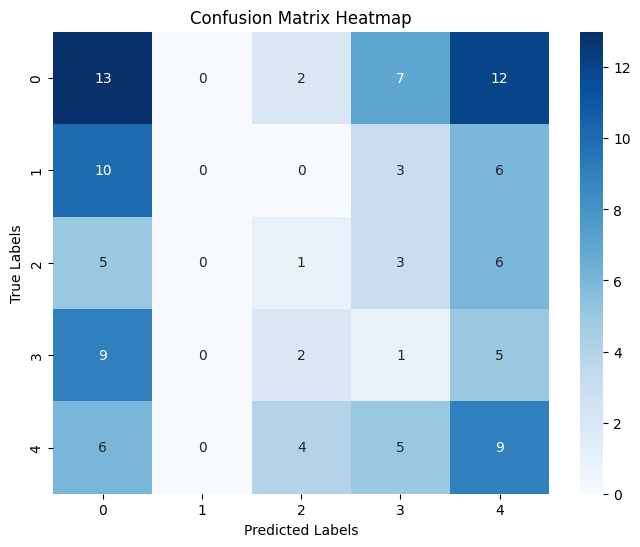

In [19]:
# Calculate accuracy - FIXED to use windowed labels
train_accuracy = accuracy_score(y_train_windowed, y_train_pred)
test_accuracy = accuracy_score(y_test_windowed, y_test_pred)

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

# Generate the confusion matrix - FIXED to use windowed labels
conf_matrix = confusion_matrix(y_test_windowed, y_test_pred, labels=range(len(labels)))

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()